### What is in between

#### Task Instructions

1. Pick any dataset linked to polygon geometries used in previous chapters of the course. Or any of your own, if you wish.

2. Create a hexagonal grid of a reasonable resolution covering the area of your data.

3. Interpolate data to the grid. Make sure to use extensive and intensive variables correctly.

4. Do you understand the difference in how the intensive variables are interpolated vs. the extensive?

5. If you don’t have a categorical column in your data, create one. Interpolate this categorical column to the grid. What is different when dealing with categorical data?


In [1]:
import geopandas as gpd
import pandas as pd
import tobler
import pyinterpolate
import numpy as np
import matplotlib.pyplot as plt
from libpysal import graph
from sklearn import neighbors
from scipy import interpolate

#### Load source data to dataframe

In [2]:
# load another ds
file = '../04_spatial_weights/data/zony_suburbanizace_2008_2016.shp'

gdf_suburban = gpd.read_file(file, engine='pyogrio')
gdf_suburban = gdf_suburban.set_index('OBJECTID')


#### Convert to geopandas geodataframe

In [3]:
grid_6 = tobler.util.h3fy(gdf_suburban, resolution=6)
grid_6 = grid_6.to_crs("EPSG:5514")

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pyproj\crs\crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


#### Plot the data to compare hex size with zones

In [ ]:
m = grid_6.explore()
# Add district boundaries
gdf_suburban.explore(
    m=m,
    color="white",
    style_kwds=dict(weight=1, opacity=0.8),
    popup=True,
    # }
)

In [4]:
gdf_suburban['zmena_vy_merge'] = gdf_suburban['zmena_vy_1'].fillna(gdf_suburban['zmena_vy_2'])
gdf_suburban[['obec_nazev', 'zmena_vy_1', 'zmena_vy_2', 'zmena_vysv', 'byty_09_16']]
gdf_suburban['byty_09_16'] = gdf_suburban['byty_09_16'].fillna(0)
gdf_suburban['obyv_31122'] = gdf_suburban['obyv_31122'].fillna(0)
gdf_suburban['obyv_31122'] = gdf_suburban['obyv_31122'].replace('?', 0)
gdf_suburban['obyv_31122'] = gdf_suburban['obyv_31122'].astype(int)


In [5]:
gdf_suburban['zmena_vy_merge'] = gdf_suburban['zmena_vy_merge'].replace([None], 'neni znamo')


In [6]:
gdf_suburban['byty_na_obyv'] = gdf_suburban['byty_09_16'] / gdf_suburban['obyv_31122']
gdf_suburban['byty_na_obyv'] = gdf_suburban['byty_na_obyv'].fillna(0)
gdf_suburban['byty_na_obyv'] = gdf_suburban['byty_na_obyv'].replace([np.inf, -np.inf], 0)


In [7]:
gdf_area_interpolate = tobler.area_weighted.area_interpolate(
    source_df=gdf_suburban,
    target_df=grid_6,
    extensive_variables=["byty_09_16", "obyv_31122"],
    intensive_variables=["byty_na_obyv"],
    categorical_variables=["zmena_vy_merge"]
)

In [ ]:
gdf_area_interpolate.explore()

### Point interpolation

In [8]:
data_airbnb = "http://data.insideairbnb.com/czech-republic/prague/prague/2023-06-24/data/listings.csv.gz"
df_airbnb = pd.read_csv(data_airbnb, compression='gzip')
# convert price to float and fill na with 0
df_airbnb.loc[:, 'price'] = df_airbnb['price'].str.replace('$', '').str.replace(',', '').astype(float)

# extract single-room apartments

df_airbnb = df_airbnb[(df_airbnb["property_type"] == "Entire rental unit") & (df_airbnb['bedrooms'] == 1)]


In [9]:
# convert to geodataframe
df_airbnb = df_airbnb.dropna(subset=['latitude', 'longitude'])
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb['longitude'], df_airbnb['latitude'], crs='EPSG:4326'))
gdf_airbnb = gdf_airbnb.to_crs("EPSG:5514")
gdf_airbnb[["x", "y"]] = gdf_airbnb.get_coordinates()
gdf_airbnb = gdf_airbnb.drop_duplicates("geometry")
gdf_airbnb = gdf_airbnb.dropna(subset=['geometry', 'price'])
gdf_airbnb = gdf_airbnb[gdf_airbnb['price'] > 800]
gdf_airbnb = gdf_airbnb[gdf_airbnb['price'] < 10000]


In [10]:
gdf_airbnb['is_close'] = gdf_airbnb.apply(
    lambda row: gdf_airbnb[gdf_airbnb.index != row.name].distance(row.geometry).min() < 1,
    axis=1
)
gdf_airbnb = gdf_airbnb[~gdf_airbnb['is_close']]


In [ ]:
gdf_airbnb.explore()

In [11]:
gdf_praha = gdf_suburban[gdf_suburban['kraj_kod'] == 'CZ010']
# used 9 resolution insead of 10
grid_9 = tobler.util.h3fy(gdf_praha, resolution=9)
grid_9 = grid_9.to_crs("EPSG:5514")
grid_coordinates = grid_9.centroid.get_coordinates()


c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pyproj\crs\crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [ ]:
grid_9.explore()


In [12]:
interpolation_uniform = neighbors.KNeighborsRegressor(
    n_neighbors=15, weights="uniform"
)
interpolation_uniform.fit(
    gdf_airbnb[["x", "y"]], gdf_airbnb["price"]
)
price_on_grid = interpolation_uniform.predict(grid_coordinates)


In [30]:
print(f"Mean: {price_on_grid.mean()}")
print(f"Median: {np.median(price_on_grid)}")
print(f"Standard Deviation: {price_on_grid.std()}")
print(f"Min: {price_on_grid.min()}")
print(f"Max: {price_on_grid.max()}")
print(f"5th percentile: {np.percentile(price_on_grid, 5)}")
print(f"95th percentile: {np.percentile(price_on_grid, 95)}")

Mean: 1900.0757636655937
Median: 1861.5333333333333
Standard Deviation: 329.0553744135838
Min: 1280.8666666666666
Max: 4327.2
5th percentile: 1393.1666666666667
95th percentile: 2438.5333333333333


In [13]:
grid_9["knn_uniform"] = price_on_grid



<Axes: >

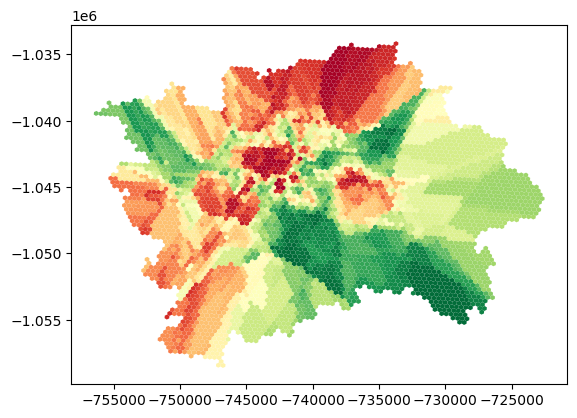

In [32]:
grid_9.plot("knn_uniform", legend=False, cmap="RdYlGn_r")

In [14]:
gdf_airbnb_coords = gdf_airbnb.get_coordinates()
x = gdf_airbnb.geometry.x
y = gdf_airbnb.geometry.y
price = gdf_airbnb['price']



In [15]:
input_data = np.column_stack((x, y, price))
input_data = input_data.astype(float)

In [16]:
exp_semivar = pyinterpolate.build_experimental_variogram(
    input_array=input_data,
    step_size=100,
    max_range=10000,
    method="ellipse"

)

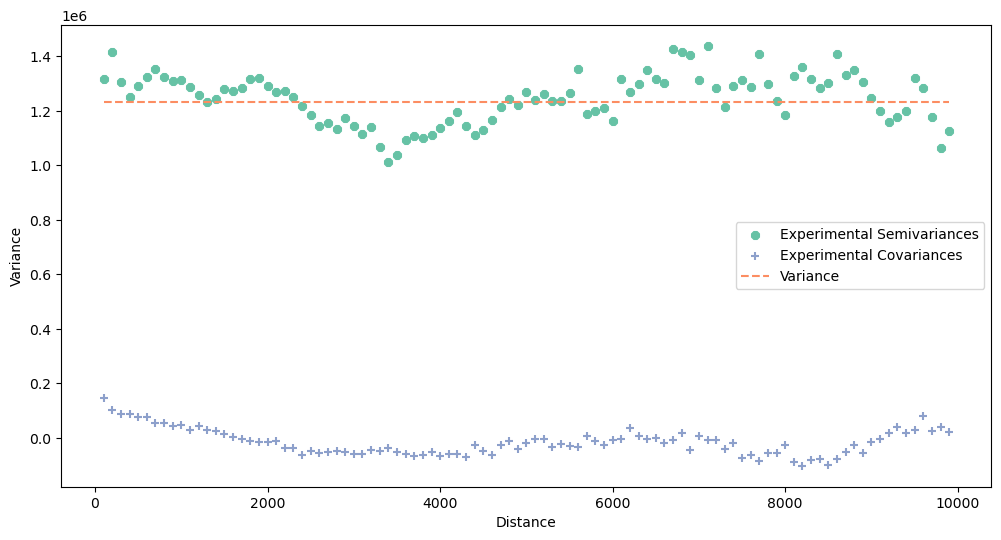

In [17]:
exp_semivar.plot()

In [18]:
semivar = pyinterpolate.build_theoretical_variogram(
    experimental_variogram=exp_semivar,
    model_name='circular',
    sill=exp_semivar.variance,
    rang=5000,
    nugget=80000)

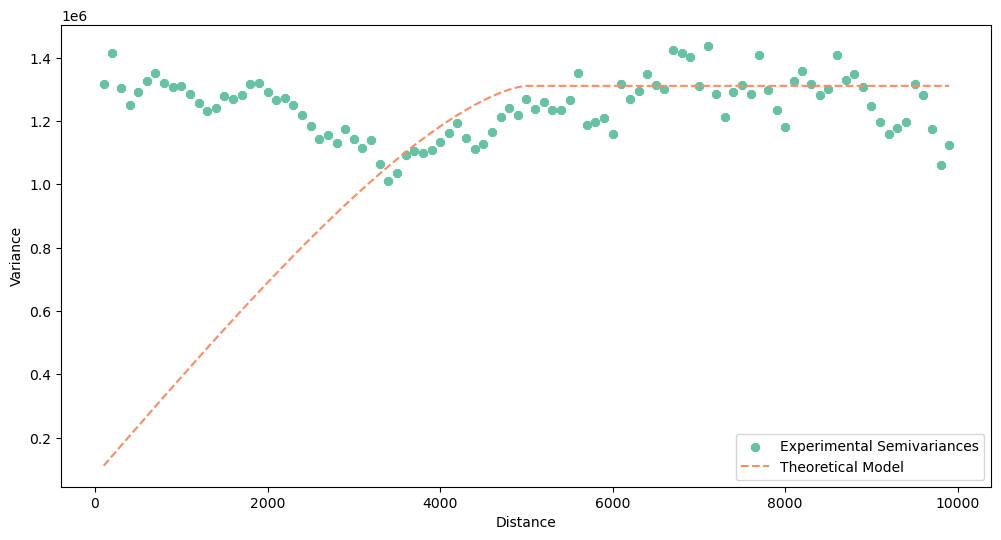

In [19]:
semivar.plot()

In [20]:
skriging = pyinterpolate.kriging(
    observations=input_data,
    theoretical_model=semivar,
    points=grid_coordinates.values,
    how="sk",
    no_neighbors=15,
    allow_approx_solutions=False,
    show_progress_bar=True,
    sk_mean=price_on_grid.mean()
)


100%|██████████| 4976/4976 [00:02<00:00, 2056.15it/s]


In [21]:
grid_9["skriging"] = skriging[:, 0]


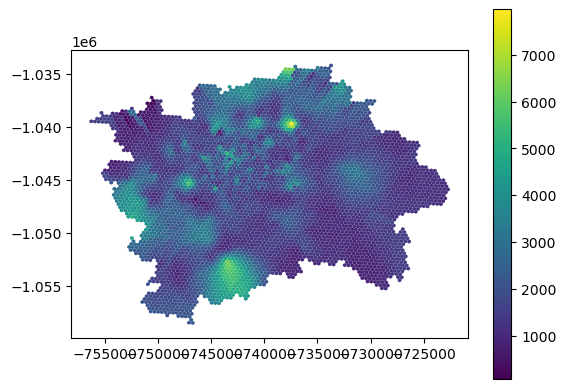

In [22]:
_ = grid_9.plot("skriging", legend=True)

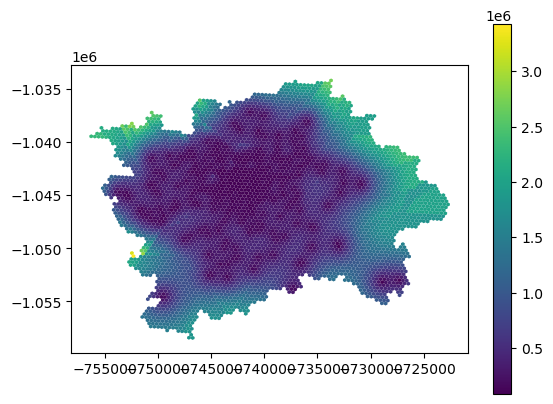

In [79]:
grid_9["variance_error"] = skriging[:, 1]
_ = grid_9.plot("variance_error", legend=True)